In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets , LaTeXStrings 
using Optim
using KernelFunctions, MAT,LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, kernelmatrix 

import StatsFuns: normcdf, normccdf, normlogcdf, normlogccdf, normlogpdf, normpdf, logsumexp

In [3]:
include("UniSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
Random.seed!(145)
xmin, xmax = -5, 5  # Bounds of the data
N          = 100 # Number of samples
xtrain     = sort(rand(Uniform(xmin, xmax), N))
xtest      = collect(range(xmin, xmax; length=400));
kernelfunc =  2*with_lengthscale(SEKernel(),1.2)
meanfunc   = (x) -> 0.0;
grammatrix = kernelmatrix(kernelfunc,xtrain,xtrain) + 1e-6*diageye(N)
ytrain     = rand(MvNormal(zeros(length(xtrain)),grammatrix))
p          = normcdf.(ytrain)
ytrainbin  = map(rand,Bernoulli.(p));
ytrainbin = float(ytrainbin);

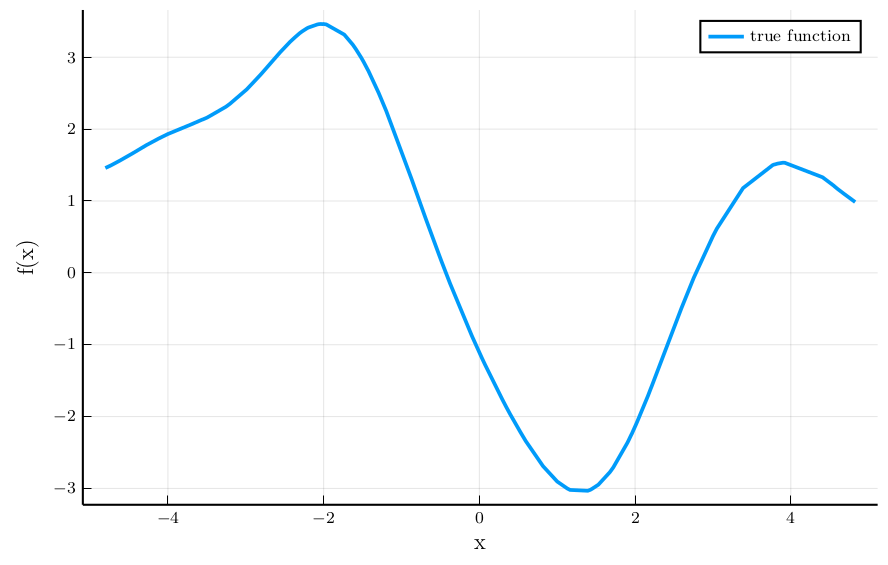

In [5]:
plot(xtrain,ytrain,label="true function",lw=1.8, legend=:topright)
xlabel!("x")
ylabel!("f(x)")

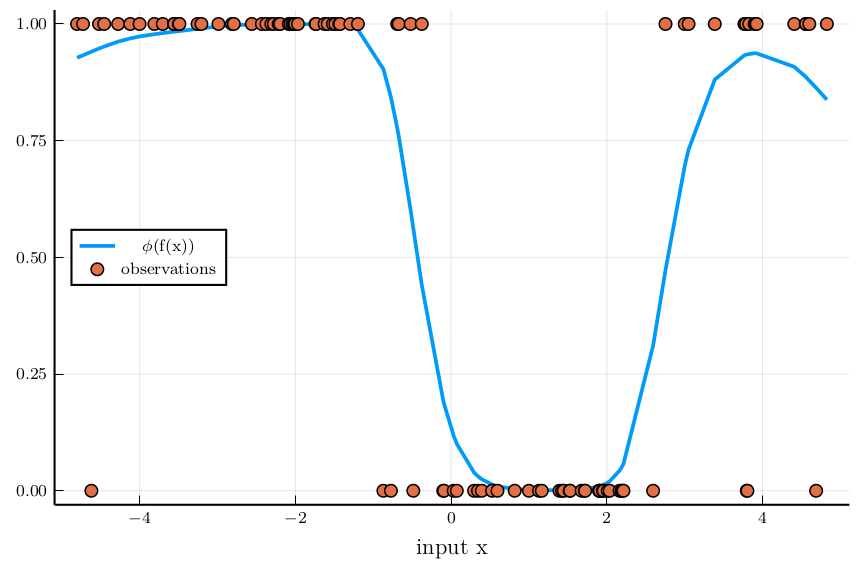

In [6]:
plot(xtrain,p,linewidth=1.8, label="ϕ(f(x))")
scatter!(xtrain,ytrainbin,legend=:left,label="observations")
xlabel!("input x")

In [8]:
Nu = 15; #number of inducing points 
Xu = range(-5.,5.;length=Nu);
mean_gp = (x) -> 0
kernel_gp(θ) = θ[1] * with_lengthscale(SEKernel(),θ[2])
Kuu = kernelmatrix(kernel_gp([1, 0.1]), Xu)
;

In [9]:
@model function gp_classification(y,x,Xu,θ)
    v ~ MvNormalMeanCovariance(zeros(length(Xu)), 50diageye(length(Xu)))
    w ~ GammaShapeRate(0.01,0.01)
    for i in eachindex(y)
        f[i] ~ UniSGP(x[i],v,w,θ) 
        y[i] ~ Probit(f[i])
    end
end

gp_constraints = @constraints begin
    q(f,v,w) = q(f)q(v)q(w)
end

@meta function meta_gp_classification(Xu,kernel)
    UniSGP() -> UniSGPMeta(nothing,Xu,kernel)
    Probit() -> ProbitMeta(32)
end

gp_initialization = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(length(Xu)), 50diageye(length(Xu)))
    q(w) = GammaShapeRate(1e-2,1e-2)
end
;

In [14]:
function my_free_energy(θ)
    
    infer_result = infer(
        model = gp_classification(Xu = Xu, θ = θ),
        iterations = 50,
        data = (y = ytrainbin, x = xtrain,),
        initialization = gp_initialization,
        constraints = gp_constraints,
        meta = meta_gp_classification(Xu,kernel_gp),
        free_energy = true,
    )
    
    return infer_result.free_energy[end]
end

function learn_params(θ,iteration)
    lower = [0.1,0.1]
    upper = [2,2]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [16]:
θ_init = [1.,1.]
θ_optimal = learn_params(θ_init,10)

2-element Vector{Float64}:
 0.21584909181110562
 1.36216651443392

## Inference

In [31]:
niter = 100

infer_result = infer(
    model = gp_classification(Xu = Xu,θ = θ_optimal,),
    iterations = niter,
    data = (y = ytrainbin, x = xtrain),
    constraints = gp_constraints,
    initialization = gp_initialization,
    meta = meta_gp_classification(Xu,kernel_gp),
    returnvars = (v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (w, v)
  Free Energy:     | Real[77.4027, 64.5291, 58.0669, 54.3117, 51.9149, 50.2748, 49.0913, 48.2005, 47.5064, 46.9499  …  41.669, 41.667, 41.6652, 41.6637, 41.6623, 41.6612, 41.6603, 41.6595, 41.6589, 41.6585]


In [32]:
qv = infer_result.posteriors[:v]
qw = infer_result.posteriors[:w];

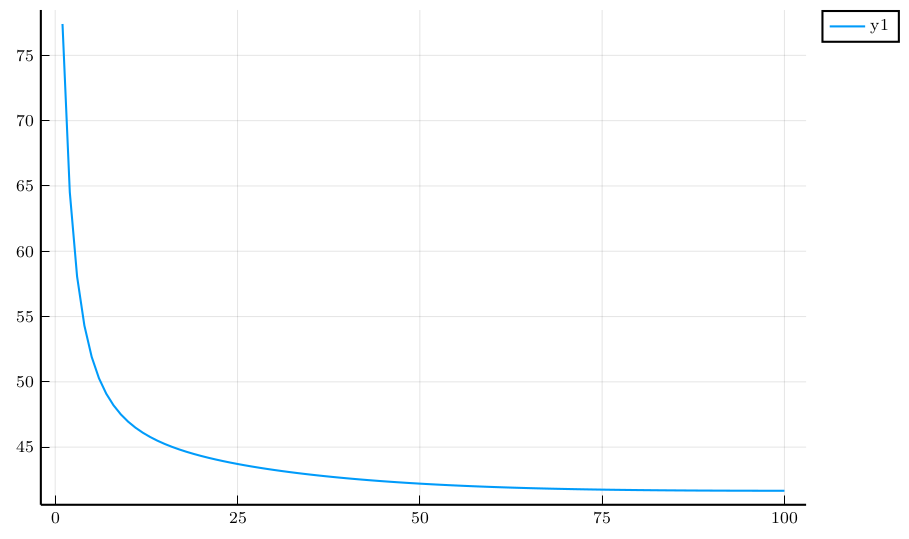

In [33]:
plot(infer_result.free_energy)

In [34]:
function predict_new(x_test,qv,qw, qθ, meta)
    prediction_f = @call_rule UniSGP(:out, Marginalisation) (q_in=PointMass(x_test),q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    prediction_y = @call_rule Probit(:out, Marginalisation) (m_in=prediction_z,meta=ProbitMeta(32))
    return prediction_f, prediction_y
end

predict_new (generic function with 1 method)

In [35]:
predict_mean =[]
predict_var =[]
predict_func=[]
predict_var_func=[]
for i=1:length(xtest)
    prediction_f, prediction_y = predict_new(xtest[i],qv,qw,PointMass(θ_optimal), UniSGPMeta(nothing,Xu,kernel_gp))
    append!(predict_func,mean(prediction_f))
    append!(predict_var_func,var(prediction_f)) 
    append!(predict_mean,mean(prediction_y))
    append!(predict_var,var(prediction_y)) 
end

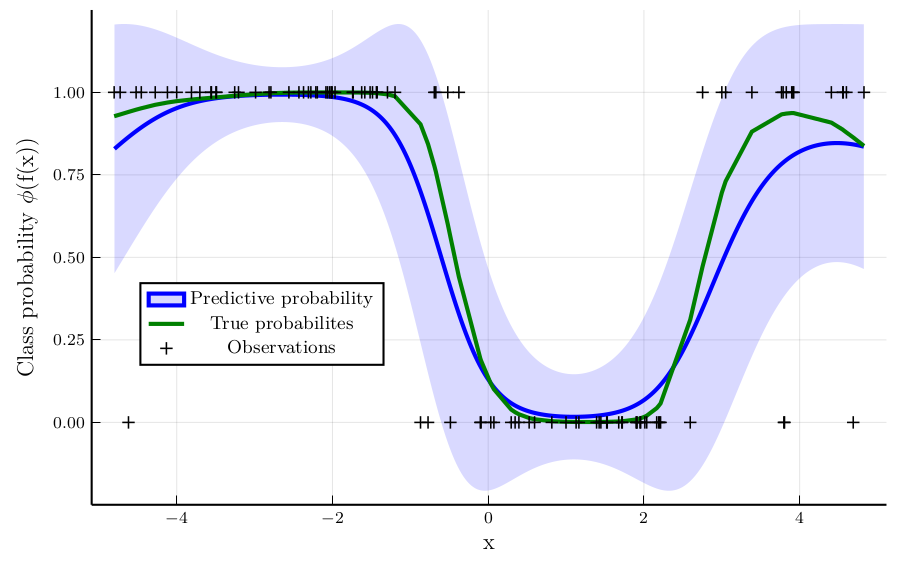

In [49]:
plot(xtest[9:393],predict_mean[9:393],ribbon = sqrt.(predict_var[9:393]),
    lw=2,label="Predictive probability",color=:blue,
    fillalpha=0.15, fontfamily="monospace",legendfontsize=9)
plot!(xtrain,p,linewidth=2,label="True probabilites",legend_position=(0.06,0.45),color=:green)
scatter!(xtrain,ytrainbin,label="Observations",marker=:cross)
xlabel!("x")
ylabel!("Class probability ϕ(f(x))")

In [50]:
savefig("texfiles/classification_ProbabilityResult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/classification_ProbabilityResult.svg"

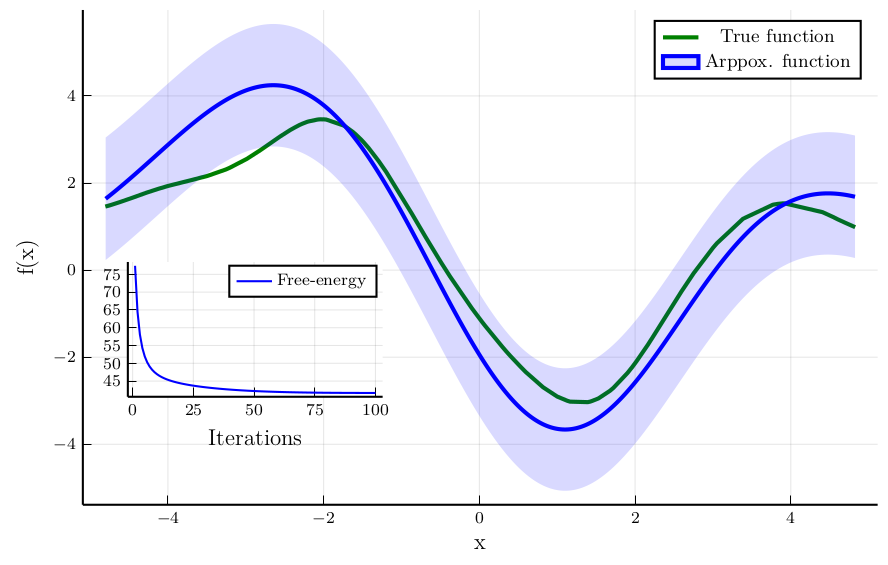

In [53]:
plot(xtrain,ytrain,label="True function",lw=2,color=:green)
plot!(xtest[9:393],predict_func[9:393],ribbon = sqrt.(predict_var_func[9:393]),
     label="Arppox. function",lw=2, legend=:topright, color=:blue,
     fillalpha=0.15, fontfamily="monospace",legendfontsize=9)
xlabel!("x")
ylabel!("f(x)")
plot!(infer_result.free_energy,label="Free-energy", legend=:topright, 
        xlabel="Iterations",
        color=:blue,
        inset = (1, bbox(0.05, 0.18, 0.4, 0.4, :bottom, :left)),
        subplot = 2)

In [54]:
savefig("texfiles/classification_FunctionResult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/classification_FunctionResult.svg"